# Predictive Maintenance  - Regression Approach

<h3>Task 1 - build a model to answer a question</h3>
<body> question: Model the err, and errf columns for individual 'scanners' to show a expected failure rate of the encoder component. 
Scanners identified into two groups, based on the following criteria and grouping:
<ul>never fail: scanners whom never reach the 12 % range for err</ul>
<ul>routinely fail: scanners whom reach the 12% range for err on a routine basis</ul>
err and errf are both float values, they are loosely tied to each other, and are not a 1 for 1 relationship, e.g. a rising err value doesn't mean a errf value will rise, nor the opposite.  
Failure is defined as a err that is above 12 % and/or a errf that is above 0.5 %

background:  err and errf represent a encoder error rate at which a led light is pulsating into a window barrier.  This barrier, and subsequent calculation, represent the rate of rotation of a component, and the compensated ERRor and ERRor Filtered value. 
</body> 
<h3>task 3 - explain why the model was chosen to answer the question asked </h3>

<h3>task 4 - explain the performance of the model, and of other models that would prove the same question.</h3>

<h3>task-5: Build documentation and share it across.</h3>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('seaborn-whitegrid')
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import metrics

import re
import mypyutil as mpy

import mypyutil as mpy

In [3]:
df = pd.read_csv("RandomforestAssignment.csv", parse_dates=['date'],infer_datetime_format=True)

In [4]:
df.head(500)

,date,scanner,min,max,err,pixels,minf,maxf,errf,updated_at
0,2017-12-17,K219,35435,35933,1.40,6,35681,35688,0.02,'2017-12-29 16:26:16.475205'
1,2017-12-18,H161,35155,36382,3.43,14,35731,35761,0.08,'2017-12-29 16:26:16.872783'
2,2017-12-18,K211,35305,36042,2.07,43,35692,35739,0.13,'2017-12-19 18:10:57.453846'
3,2017-12-18,K212,35216,36225,2.82,61,35686,35726,0.11,'2017-12-19 18:10:57.45983'
4,2017-12-18,K220,35196,36259,2.98,11,35709,35724,0.04,'2017-12-19 18:10:57.464388'
...,...,...,...,...,...,...,...,...,...,...
495,2017-12-29,K250,35232,36040,2.27,17,35696,35709,0.04,?
496,2017-12-30,K237,35459,36026,1.59,12,35711,35719,0.02,?
497,2017-12-30,K238,35115,36354,3.47,7,35709,35716,0.02,?
498,2017-12-30,K239,35169,36391,3.42,21,35721,35728,0.02,?


__Note:__
__*From the Updated at value we can get the duration of which the scanner worked before doing the measurement*__

In [5]:
df = df.drop(['updated_at','date'], axis = 1) 
df = df.loc[~((df['min']<=0) & (df['max']<=0) & (df['err'] <= 0)),:]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2603 entries, 0 to 2751
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   scanner  2603 non-null   object 
 1   min      2603 non-null   int64  
 2   max      2603 non-null   int64  
 3   err      2603 non-null   float64
 4   pixels   2603 non-null   int64  
 5   minf     2603 non-null   int64  
 6   maxf     2603 non-null   int64  
 7   errf     2603 non-null   float64
dtypes: float64(2), int64(5), object(1)
memory usage: 183.0+ KB


In [7]:
df.head()

,scanner,min,max,err,pixels,minf,maxf,errf
0,K219,35435,35933,1.40,6,35681,35688,0.02
1,H161,35155,36382,3.43,14,35731,35761,0.08
2,K211,35305,36042,2.07,43,35692,35739,0.13
3,K212,35216,36225,2.82,61,35686,35726,0.11
4,K220,35196,36259,2.98,11,35709,35724,0.04


In [8]:
df.columns

Index(['scanner', 'min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf'], dtype='object')

In [9]:
from numpy import absolute
df['MaxMinDiff'] = absolute(df['max']-df['min'])

df['MaxfMinfDiff'] = absolute(df['maxf']-df['minf'])



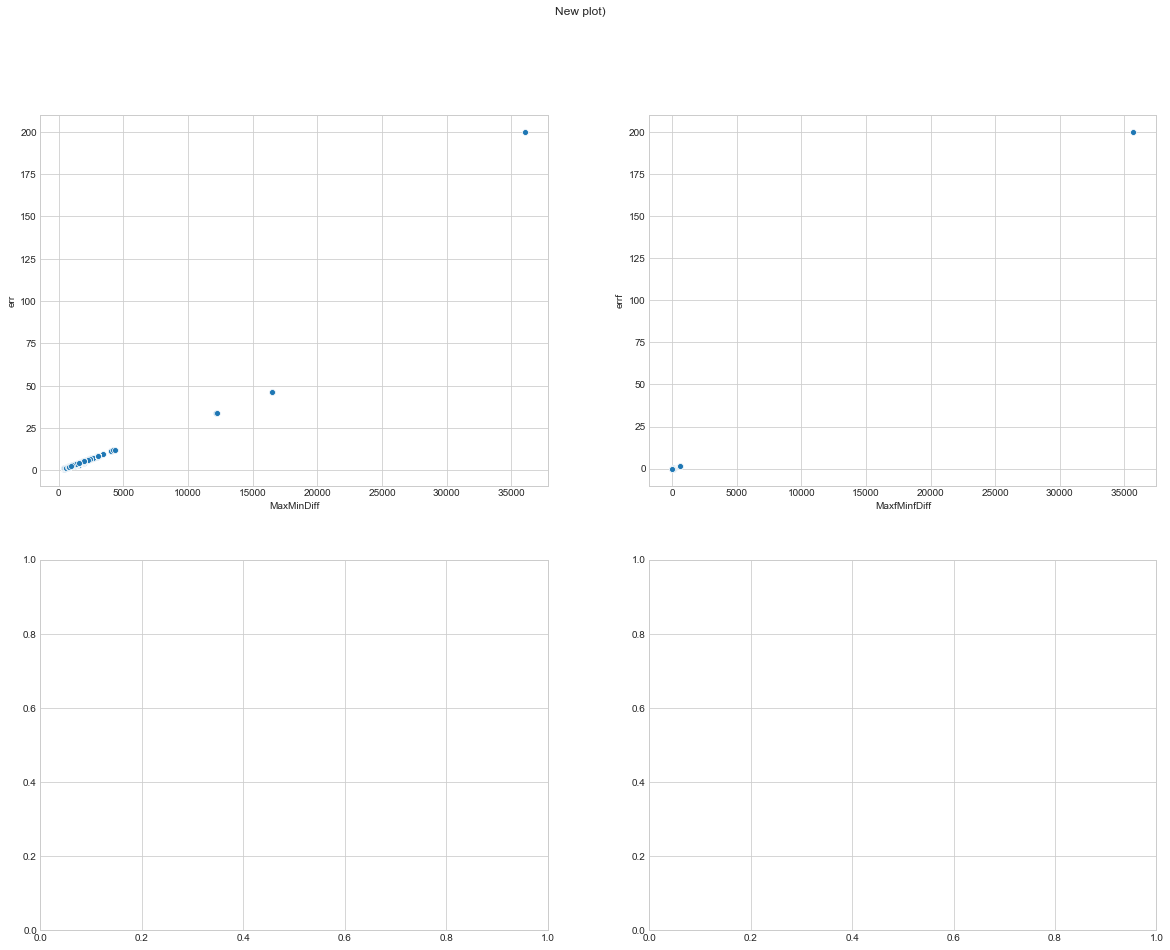

In [10]:
f, axes = plt.subplots(2,2, figsize=(20, 15), facecolor='white')
f.suptitle('New plot)')
sns.scatterplot(x=df['MaxMinDiff'],y=df['err'],palette ="Set1",ax=axes[0,0])
sns.scatterplot(x=df['MaxfMinfDiff'],y=df['errf'],palette ="Set1", ax=axes[0,1])


In [57]:
import plotly.express as px

fig = px.scatter_3d(df_outlier, x='MaxMinDiff', y='err', z='pixels',
              color='scanner')
fig.show()

In [11]:
df_copy = df.drop('scanner',axis =1)
df_copy['Failure'] = np.where((df_copy['err'] >= 12.0) | (df_copy['errf'] >=0.5),2, 1)
df_copy['Failure'].unique()

array([1, 2])

In [12]:
df_copy['Failure'].value_counts()

1    2591
2      12
Name: Failure, dtype: int64

In [13]:
df_copy['scanner']= df['scanner']

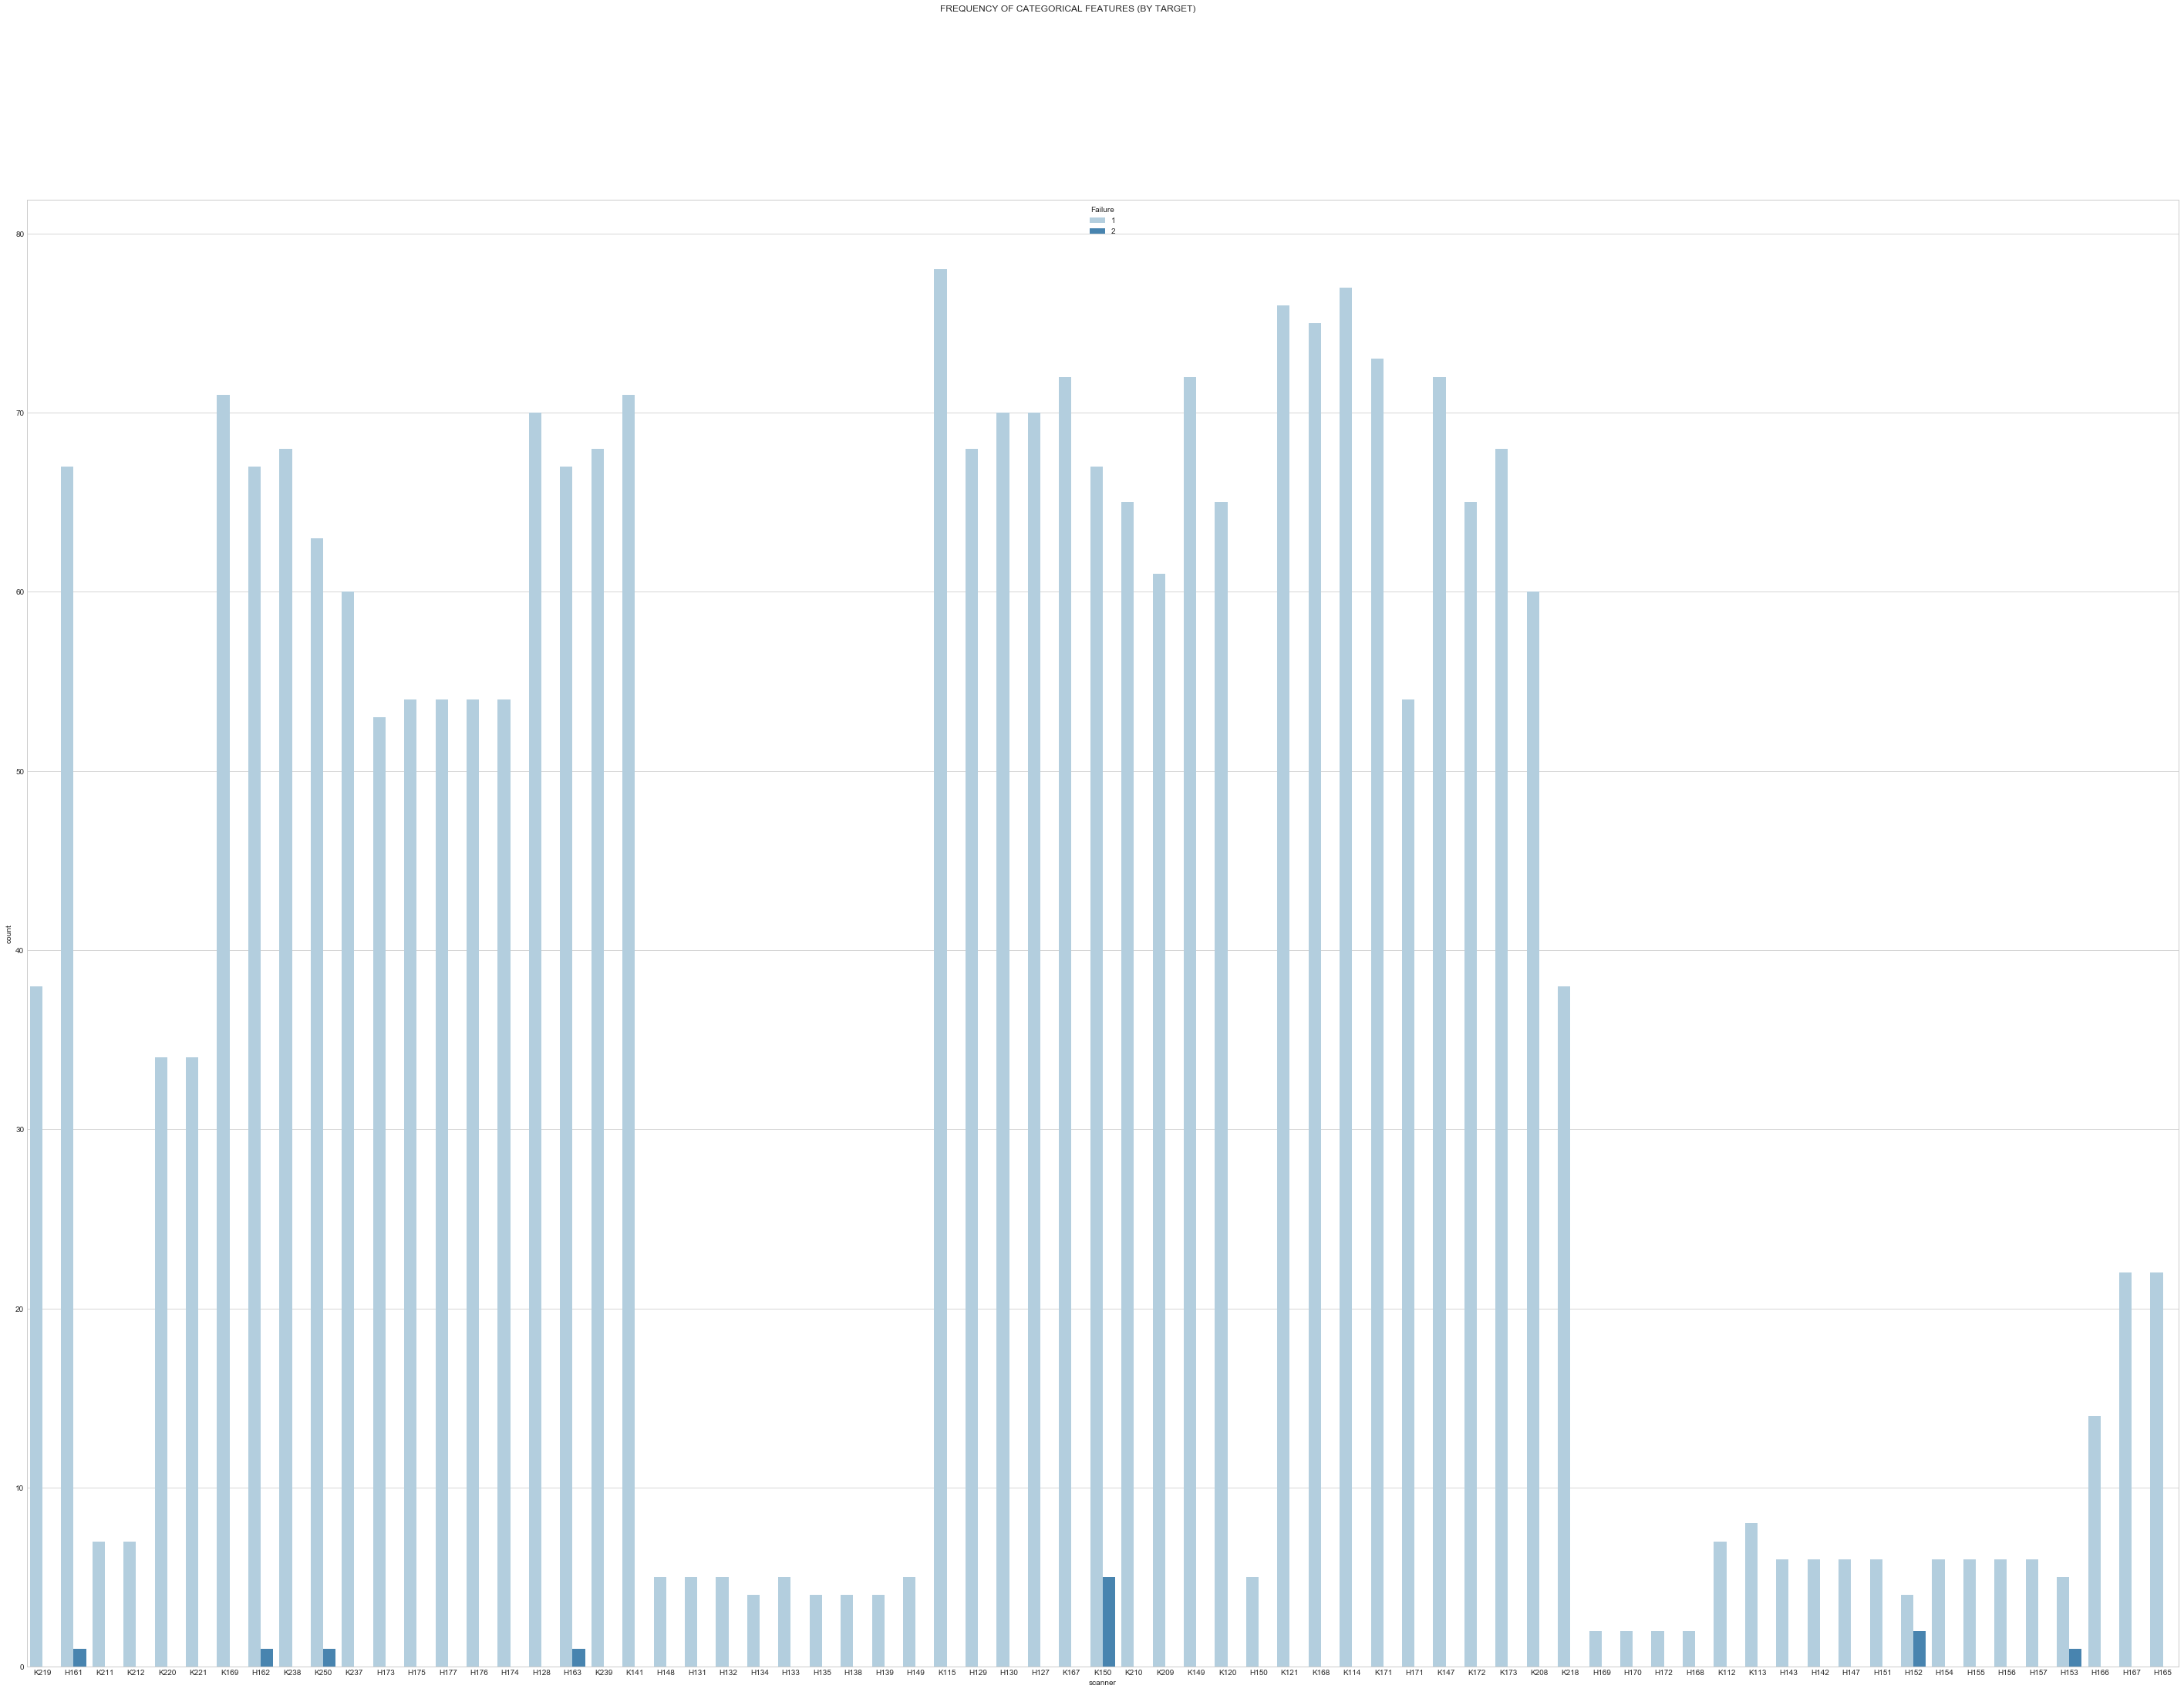

In [14]:
# Creating a new dataframe with categorical variables


f, axes = plt.subplots(1, 1, figsize=(50, 35), facecolor='white')
f.suptitle('FREQUENCY OF CATEGORICAL FEATURES (BY TARGET)')
sns.countplot(x="scanner", hue="Failure", data=df_copy, palette="Blues")


In [15]:
df_cp = pd.concat([df_copy,pd.get_dummies(df_copy['scanner'], prefix='scanner',dummy_na=True)],axis=1).drop(['scanner'],axis=1)

In [16]:
df_cp.head()

,min,max,err,pixels,minf,maxf,errf,MaxMinDiff,MaxfMinfDiff,Failure,...,scanner_K212,scanner_K218,scanner_K219,scanner_K220,scanner_K221,scanner_K237,scanner_K238,scanner_K239,scanner_K250,scanner_nan
0,35435,35933,1.40,6,35681,35688,0.02,498,7,1,...,0,0,1,0,0,0,0,0,0,0
1,35155,36382,3.43,14,35731,35761,0.08,1227,30,1,...,0,0,0,0,0,0,0,0,0,0
2,35305,36042,2.07,43,35692,35739,0.13,737,47,1,...,0,0,0,0,0,0,0,0,0,0
3,35216,36225,2.82,61,35686,35726,0.11,1009,40,1,...,1,0,0,0,0,0,0,0,0,0
4,35196,36259,2.98,11,35709,35724,0.04,1063,15,1,...,0,0,0,1,0,0,0,0,0,0


In [17]:
df_cp.columns

Index(['min', 'max', 'err', 'pixels', 'minf', 'maxf', 'errf', 'MaxMinDiff',
       'MaxfMinfDiff', 'Failure', 'scanner_H127', 'scanner_H128',
       'scanner_H129', 'scanner_H130', 'scanner_H131', 'scanner_H132',
       'scanner_H133', 'scanner_H134', 'scanner_H135', 'scanner_H138',
       'scanner_H139', 'scanner_H142', 'scanner_H143', 'scanner_H147',
       'scanner_H148', 'scanner_H149', 'scanner_H150', 'scanner_H151',
       'scanner_H152', 'scanner_H153', 'scanner_H154', 'scanner_H155',
       'scanner_H156', 'scanner_H157', 'scanner_H161', 'scanner_H162',
       'scanner_H163', 'scanner_H165', 'scanner_H166', 'scanner_H167',
       'scanner_H168', 'scanner_H169', 'scanner_H170', 'scanner_H171',
       'scanner_H172', 'scanner_H173', 'scanner_H174', 'scanner_H175',
       'scanner_H176', 'scanner_H177', 'scanner_K112', 'scanner_K113',
       'scanner_K114', 'scanner_K115', 'scanner_K120', 'scanner_K121',
       'scanner_K141', 'scanner_K147', 'scanner_K149', 'scanner_K150',
      

In [18]:
df_cp = df_cp.drop('scanner_nan', axis =1)

In [19]:
print(df_cp['min'].value_counts())

35186    72
35232    23
35318    15
35313    15
35320    15
         ..
35515     1
34458     1
35238     1
34450     1
35517     1
Name: min, Length: 723, dtype: int64


In [20]:
df_cp['min'] = np.where(df_cp['min'] == -1,df_cp['min'].mean(),df_cp['min'])
df_cp['max'] = np.where(df_cp['max'] == -1,df_cp['max'].mean(),df_cp['max'])

In [21]:
df_cp['max'].describe()

count     2603.000000
mean     36200.400307
std        554.719813
min      35761.000000
25%      36007.500000
50%      36119.000000
75%      36264.000000
max      47057.000000
Name: max, dtype: float64

In [22]:
df_cp.columns.size

79

In [23]:
# Original dataset

df_f = df_cp.drop('Failure', axis=1)  
X = df_f.drop(['err','errf'],axis = 1)

columns = ['err','errf']
y = pd.DataFrame(df_f, columns=columns)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [25]:
gbr = GradientBoostingRegressor()
model = MultiOutputRegressor(estimator=gbr)
print(model)

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls', max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_

In [26]:
#cv.fit(X_train, y_train)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls', max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_

In [27]:
score = model.score(X_train, y_train)
print(score)

0.9999892247393851


In [29]:
y_pred= model.predict(X_test)

print("y1 MSE:%.4f" % mean_squared_error(y_test["err"], y_pred[:,0]))
print("y2 MSE:%.4f" % mean_squared_error(y_test["errf"], y_pred[:,1]))

y1 MSE:0.0445
y2 MSE:0.0000


In [30]:

from sklearn.model_selection import RepeatedKFold
from numpy import absolute

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
cv_scores =cross_val_score(model, X, y, cv=cv)




In [31]:
from numpy import absolute
from numpy import mean
from numpy import std

# summarize performance
cv_scores = absolute(cv_scores)
print('Result: %.4f (%.4f)' % (mean(cv_scores), std(cv_scores)))


Result: 0.9099 (0.2689)


In [32]:
def multi_out_regression(mod_est): 
      brk_str = '=='*50     
      model_rf = MultiOutputRegressor(estimator=mod_est)
      print(model_rf)
      print(brk_str)
      model_rf.fit(X_train, y_train)


      score_rf = model_rf.score(X_train, y_train)
      print(score_rf)
      print(brk_str)

      y_pred= model_rf.predict(X_test)

      print("y1 MSE:%.4f" % mean_squared_error(y_test["err"], y_pred[:,0]))
      print("y2 MSE:%.4f" % mean_squared_error(y_test["errf"], y_pred[:,1]))

      cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
      cv_scores_rf =cross_val_score(model_rf, X, y, cv=cv)
      print(brk_str)
      cv_scores_rf = absolute(cv_scores_rf)
      print('Result: %.4f (%.4f)' % (mean(cv_scores_rf), std(cv_scores_rf)))

In [33]:
multi_out_regression( RandomForestRegressor())

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                              

In [34]:
from sklearn.svm import LinearSVR
multi_out_regression( LinearSVR())

MultiOutputRegressor(estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                         fit_intercept=True,
                                         intercept_scaling=1.0,
                                         loss='epsilon_insensitive',
                                         max_iter=1000, random_state=None,
                                         tol=0.0001, verbose=0),
                     n_jobs=None)
0.9995300370392375
y1 MSE:0.0397
y2 MSE:0.0088
Result: 0.5138 (0.1548)


In [35]:
from sklearn.linear_model import LinearRegression

multi_out_regression(LinearRegression() )


MultiOutputRegressor(estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                                n_jobs=None, normalize=False),
                     n_jobs=None)
0.9999996222549714
y1 MSE:0.0001
y2 MSE:0.0000
Result: 8158148640159302656.0000 (40550878611791126528.0000)


In [36]:
from sklearn.neighbors import KNeighborsRegressor

multi_out_regression(KNeighborsRegressor())

MultiOutputRegressor(estimator=KNeighborsRegressor(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=5,
                                                   p=2, weights='uniform'),
                     n_jobs=None)
0.4599105309573759
y1 MSE:0.8377
y2 MSE:0.0044
Result: 0.8262 (0.2319)


In [37]:
multi_out_regression( GradientBoostingRegressor())

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls', max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_

In [38]:
from sklearn.tree import DecisionTreeRegressor
multi_out_regression(DecisionTreeRegressor())

MultiOutputRegressor(estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=None,
                                                     splitter='best'),
                     n_jobs=None)
1.0
y1 

In [39]:

sampleTest = df_cp.loc[(df_cp['scanner_K150'] == 1) & (df_cp['Failure'] == 2)]

In [40]:
print(sampleTest)

min      max    err  pixels   minf   maxf  errf  MaxMinDiff  \
1446  33509.0  37801.0  12.04      18  35708  35726  0.05        4292   
1512  33509.0  37792.0  12.01      18  35709  35725  0.04        4283   
1553  33478.0  37815.0  12.17      21  35707  35728  0.06        4337   
1766  27443.0  43960.0  46.26      34  35708  35727  0.05       16517   
1771  27443.0  43960.0  46.26      34  35708  35727  0.05       16517   

      MaxfMinfDiff  Failure  ...  scanner_K211  scanner_K212  scanner_K218  \
1446            18        2  ...             0             0             0   
1512            16        2  ...             0             0             0   
1553            21        2  ...             0             0             0   
1766            19        2  ...             0             0             0   
1771            19        2  ...             0             0             0   

      scanner_K219  scanner_K220  scanner_K221  scanner_K237  scanner_K238  \
1446             0      

In [41]:
ypred_valid = model.predict(sampleTest.drop(['err','errf','Failure'],axis = 1))

In [42]:
print(ypred_valid)

[[1.20263987e+01 4.97716063e-02]
 [1.19977927e+01 4.14610536e-02]
 [1.20749414e+01 5.97728880e-02]
 [4.62344293e+01 4.97716063e-02]
 [4.62344293e+01 4.97716063e-02]]


In [43]:
res = np.where((ypred_valid[:,0] >= 12.0) | (ypred_valid[:,1] >=0.5),2, 1)

In [44]:
res

array([2, 1, 2, 2, 2])

Final thought before modeling

The difference between Max and Min increases then the scanner will likly towards failure after the value becomes 4000 and above
The difference between Maxf and Minf increases then the scanner will likly towards failure after the value becomes 100/90 and above

Failure category:
Never fail : Failure = 1
Routinely fail: Failure = 2
Expected to fail/Failing faster: Failure = 3

Based on the model prediction value, we can drive the category mentioned above 

GradientBoostingRegressor gives good result.